## Main

In [1]:
#1
import pandas as pd  # Import pandas to handle structured data (CSV files)

# Load dataset containing news articles
df = pd.read_csv("dataset/data.csv")  

# Display basic information about the dataset (column names, data types, missing values, etc.)
print(df.info())  

# Display the first few rows of the dataset to check its structure
print(df.head())  

# We first load the data to see what we’re working with. 
# It includes headlines, news content, topics, and labels showing whether the news is real or fake.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39942 entries, 0 to 39941
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    39942 non-null  int64 
 1   title    39942 non-null  object
 2   text     39942 non-null  object
 3   subject  39942 non-null  object
 4   date     39942 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB
None
   label                                              title  \
0      1  As U.S. budget fight looms, Republicans flip t...   
1      1  U.S. military to accept transgender recruits o...   
2      1  Senior U.S. Republican senator: 'Let Mr. Muell...   
3      1  FBI Russia probe helped by Australian diplomat...   
4      1  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  polit

In [2]:
#2
import re  # Regular expressions for text cleaning
import string  # String operations to remove punctuation
import nltk  # Natural Language Toolkit (NLTK) for text processing
from nltk.corpus import stopwords  # Import stop words to remove unnecessary words
from nltk.tokenize import word_tokenize  # Tokenization (splitting text into words)
from nltk.stem import WordNetLemmatizer  # Lemmatization (converting words to their root form)

# Download necessary NLTK data files (only needs to be run once)
nltk.download('punkt')  # Tokenizer data
nltk.download('stopwords')  # Stopwords data (common words like "the", "is", etc.)
nltk.download('wordnet')  # WordNet dictionary for lemmatization

# Initialize tools
stop_words = set(stopwords.words('english'))  # Set of stopwords in English
lemmatizer = WordNetLemmatizer()  # Initialize lemmatizer to get base form of words


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mohammed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mohammed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mohammed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#3
def clean_text(text):
    text = text.lower()  # Convert text to lowercase to maintain consistency
    text = re.sub(r'\d+', '', text)  # Remove numbers since they don't contribute to meaning
    text = re.sub(r'[^\w\s]', '', text)  # Remove all punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize the text (split into words)
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Convert words to their base form
    return " ".join(tokens)  # Join words back into a single string

# Apply text cleaning function to 'title' and 'text' columns, then combine them
df['cleaned_text'] = df['title'] + " " + df['text']
df['cleaned_text'] = df['cleaned_text'].apply(clean_text)

# Print the first few cleaned rows to verify text preprocessing
print(df['cleaned_text'].head())

# We clean the text by making everything lowercase, removing unnecessary words, 
# and simplifying words to their root form. This helps our model focus on important words.


0    u budget fight loom republican flip fiscal scr...
1    u military accept transgender recruit monday p...
2    senior u republican senator let mr mueller job...
3    fbi russia probe helped australian diplomat ti...
4    trump want postal service charge much amazon s...
Name: cleaned_text, dtype: object


In [4]:
## 4 Split Data for Training and Testing
from sklearn.model_selection import train_test_split  # Import function to split dataset

# Define features (text) and target variable (label: 0 = fake, 1 = real)
X = df['cleaned_text']
y = df['label']

# Split dataset into 80% training and 20% testing to evaluate model performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")  # Print number of training samples
print(f"Testing samples: {len(X_test)}")  # Print number of testing samples

# We split the data so the model can learn from one part and be tested on another.
# This helps us check if it works on new articles.


Training samples: 31953
Testing samples: 7989


In [5]:
## 5 Train Word2Vec Model
import gensim  # Import Gensim for Word2Vec
from gensim.models import Word2Vec  # Word2Vec model
import numpy as np  # Import NumPy for numerical operations

# Train a Word2Vec model using the tokenized text
w2v_model = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=2, workers=4)

# We use Word2Vec instead of TF-IDF to capture word meanings instead of just word frequency.



In [6]:
## 6 Convert Text into Word2Vec Vectors
# Function to get average Word2Vec vector for a document
def document_vector(text):
    word_vectors = [w2v_model.wv[word] for word in text if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(100)  # If empty, return zeros

# Convert training and testing data into Word2Vec vectors
X_train_w2v = np.array([document_vector(text) for text in X_train])
X_test_w2v = np.array([document_vector(text) for text in X_test])

# Each document is now represented by a numerical vector instead of word frequency.



In [7]:
## 7 Train Random Forest Model with Word2Vec
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest classifier

# Train a Random Forest classifier with Word2Vec vectors
model = RandomForestClassifier(n_estimators=100, random_state=42)  # Use 100 decision trees
model.fit(X_train_w2v, y_train)

# Test the model and print accuracy
accuracy = model.score(X_test_w2v, y_test)
print(f"Word2Vec + Random Forest Accuracy: {accuracy:.2f}")

# We train a machine learning model using Random Forest to recognize patterns in the text 
# and predict if an article is fake or real. Then we test how well it performs.




Word2Vec + Random Forest Accuracy: 0.83


In [8]:
## 8 Predict on Validation Data
# Load new articles for validation
val_df = pd.read_csv("dataset/validation_data.csv")

# Clean the validation text
val_df['cleaned_text'] = (val_df['title'] + " " + val_df['text']).apply(clean_text)

# Convert validation dataset into Word2Vec vectors
X_val_w2v = np.array([document_vector(text) for text in val_df['cleaned_text']])

# Make predictions
val_df['label'] = model.predict(X_val_w2v)

# Replace any remaining label 2 values with 0 (fake)
val_df['label'] = val_df['label'].apply(lambda x: 0 if x == 2 else x)

# Save predictions
val_df.to_csv("dataset/validation_predictions_word2vec.csv", index=False)
print("Predictions saved successfully!")

# We clean and process new articles, then use our trained model to predict if they are fake or real. 
# Finally, we save the results.



Predictions saved successfully!


In [9]:
## 9 Evaluate Model Performance
from sklearn.metrics import classification_report  # Import function to check model performance

# Predict on the test set
y_pred = model.predict(X_test_w2v)

# Print classification report with precision, recall, and F1-score
print(classification_report(y_test, y_pred))

# We check how well the model performs using accuracy, precision, and recall. 
# These numbers tell us how reliable our fake news detector is.

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      3996
           1       0.83      0.83      0.83      3993

    accuracy                           0.83      7989
   macro avg       0.83      0.83      0.83      7989
weighted avg       0.83      0.83      0.83      7989



## Extra to show more

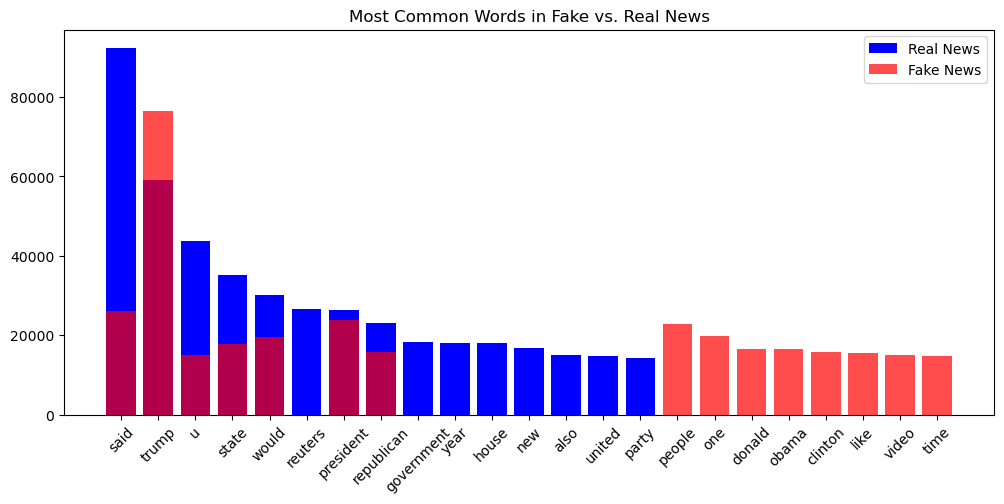

In [ ]:
#10
from collections import Counter  # Import Counter to count word occurrences
import matplotlib.pyplot as plt  # Import Matplotlib for plotting

# Get most common words in real and fake news articles
real_words = " ".join(df[df["label"] == 1]["cleaned_text"]).split()
fake_words = " ".join(df[df["label"] == 0]["cleaned_text"]).split()

real_counts = Counter(real_words).most_common(15)  # Top 15 words in real news
fake_counts = Counter(fake_words).most_common(15)  # Top 15 words in fake news

# Plot most common words in real vs. fake news
plt.figure(figsize=(12,5))
plt.bar(*zip(*real_counts), color='blue', label="Real News")
plt.bar(*zip(*fake_counts), color='red', alpha=0.7, label="Fake News")
plt.xticks(rotation=45)
plt.title("Most Common Words in Fake vs. Real News")
plt.legend()
plt.show()

# Fake news often uses dramatic words, while real news tends to have more neutral wording. 
# This chart shows the most frequent words in both categories.


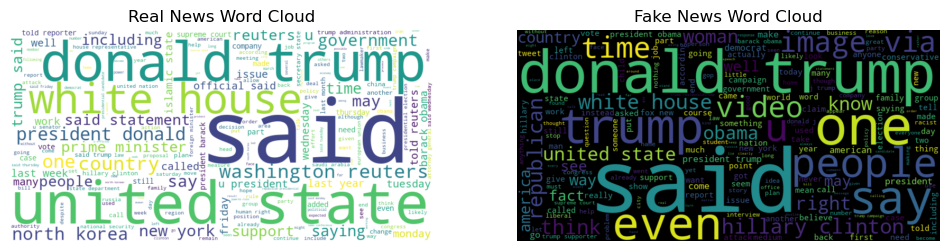

In [11]:
from wordcloud import WordCloud  # Import WordCloud to generate visual representations of text data

# Generate Word Clouds for Real and Fake News
real_wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(real_words))  
fake_wc = WordCloud(width=800, height=400, background_color="black").generate(" ".join(fake_words))

# Create a figure for displaying both word clouds
plt.figure(figsize=(12,5))  

# Display the Real News word cloud
plt.subplot(1,2,1)  # Create a subplot (1 row, 2 columns, 1st plot)
plt.imshow(real_wc, interpolation="bilinear")  # Show the word cloud image
plt.axis("off")  # Remove axis labels for cleaner display
plt.title("Real News Word Cloud")  # Add title

# Display the Fake News word cloud
plt.subplot(1,2,2)  # Create a subplot (1 row, 2 columns, 2nd plot)
plt.imshow(fake_wc, interpolation="bilinear")  # Show the word cloud image
plt.axis("off")  # Remove axis labels for cleaner display
plt.title("Fake News Word Cloud")  # Add title

# Show the final plot with both word clouds
plt.show()

# Shows most used words in real vs. fake news
# Helps detect patterns in language use



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mohammed\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


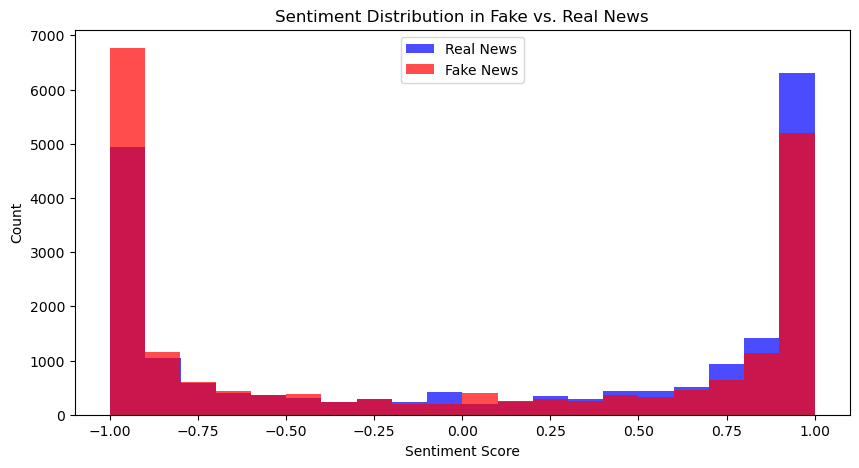

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer  # Import sentiment analysis tool

# Download sentiment analysis tool
nltk.download("vader_lexicon")  
sia = SentimentIntensityAnalyzer()  

# Compute sentiment scores for each article
df["sentiment"] = df["cleaned_text"].apply(lambda text: sia.polarity_scores(text)["compound"])  

# Plot sentiment distribution
plt.figure(figsize=(10,5))
plt.hist(df[df["label"] == 1]["sentiment"], bins=20, alpha=0.7, label="Real News", color="blue")  
plt.hist(df[df["label"] == 0]["sentiment"], bins=20, alpha=0.7, label="Fake News", color="red")  
plt.title("Sentiment Distribution in Fake vs. Real News")  
plt.xlabel("Sentiment Score")  
plt.ylabel("Count")  
plt.legend()  
plt.show()

# Measures the emotional tone of articles
# Shows if fake news is more negative or emotional




Random Forest Accuracy: 0.83
Logistic Regression Accuracy: 0.77
SVM Accuracy: 0.79


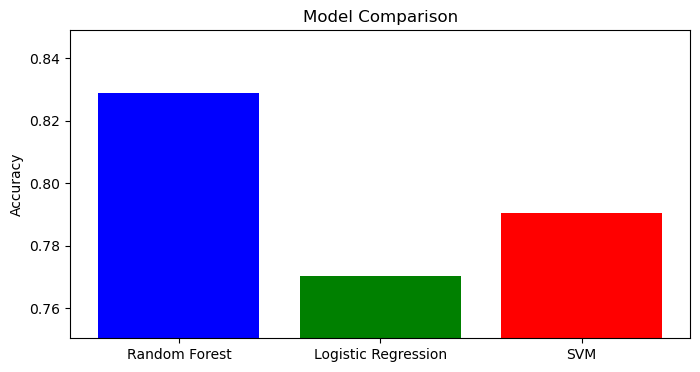

In [15]:
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest model
from sklearn.linear_model import LogisticRegression  # Import Logistic Regression model
from sklearn.svm import SVC  # Import Support Vector Machine (SVM)
from sklearn.metrics import accuracy_score  # Import accuracy evaluation
import matplotlib.pyplot as plt  # Import Matplotlib for visualization

# Define models to test (Removing MultinomialNB)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC()
}

# Train and evaluate each model using Word2Vec features
results = {}
for name, model in models.items():
    model.fit(X_train_w2v, y_train)  # Train model using Word2Vec embeddings
    y_pred = model.predict(X_test_w2v)  # Make predictions
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results[name] = accuracy  
    print(f"{name} Accuracy: {accuracy:.2f}")  

# Get min and max accuracy values for dynamic scaling
min_acc = min(results.values()) - 0.02  # Add some space below the lowest value
max_acc = max(results.values()) + 0.02  # Add some space above the highest value

# Plot model comparison
plt.figure(figsize=(8,4))
plt.bar(results.keys(), results.values(), color=["blue", "green", "red"])  # Set distinct colors
plt.title("Model Comparison")  
plt.ylabel("Accuracy")  
plt.ylim(min_acc, max_acc)  # Dynamically adjust the y-axis range
plt.show()


# Compares Random Forest, Logistic Regression, and SVM using Word2Vec embeddings




In [ ]:
# import streamlit as st  # Import Streamlit for building web apps

# st.title("Fake News Detector")  # Set app title
# user_input = st.text_area("Enter a news headline or article:")  # Text input for users

# if st.button("Check"):  # Button to make prediction
#     cleaned_input = clean_text(user_input)  # Preprocess input text
#     input_vector = vectorizer.transform([cleaned_input])  # Convert text to TF-IDF
#     prediction = model.predict(input_vector)[0]  # Make prediction
#     st.write("Prediction:", "Real News" if prediction == 1 else "Fake News")  # Show result\
            
# # Creates a simple web app where users can enter text
# # Instantly predicts whether the article is fake or real
